##  --- Environment & Imports ---

In [31]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Face utilities
from facenet_pytorch import MTCNN, InceptionResnetV1

# For clustering & visualization
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Image handling
from PIL import Image
import cv2

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

2.2.2+cu121
12.1
True
NVIDIA GeForce RTX 4080 Laptop GPU


# Phase 1: Face Data Preparation

This phase covers the full preprocessing pipeline before training:
1. **Face Detection & Cropping** – detect faces in raw images and save cropped versions.  
2. **Metadata Logging** – record filenames, probabilities, and bounding boxes.  
3. **Embedding Extraction** – generate 512‑D FaceNet embeddings for each cropped face.  
4. **Clustering** – group embeddings into clusters for manual labeling.  

In [5]:
# Initialize MTCNN detector
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(keep_all=True, device=device)
mtcnn

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

### Testing detection and cropping

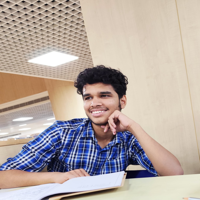

In [7]:
# Path to your test image
img_path = r"C:\Users\Archit\Desktop\Frendclassifier\Images\ALL_Images\IMG_20240509_150611.jpg_compressed.JPEG"

# Load image
img = Image.open(img_path)
resized_img = img.resize((200, 200))
resized_img

In [8]:
# Detect faces and get probabilities
faces, probs = mtcnn(img, return_prob=True)

print(f"Detected {len(faces)} face(s)")
print("Probabilities:", probs)

Detected 1 face(s)
Probabilities: [0.9999996423721313]


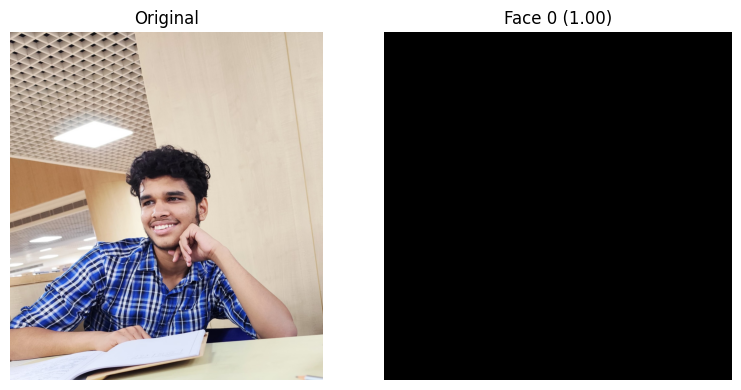

In [9]:
# Plot original + cropped faces
plt.figure(figsize=(8, 4))

# Show original
plt.subplot(1, len(faces)+1, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Original")

# Show each detected face
for i, face in enumerate(faces):
    plt.subplot(1, len(faces)+1, i+2)
    plt.imshow(face.permute(1, 2, 0).int().numpy())
    plt.axis("off")
    plt.title(f"Face {i} ({probs[i]:.2f})")

plt.tight_layout()
plt.show()

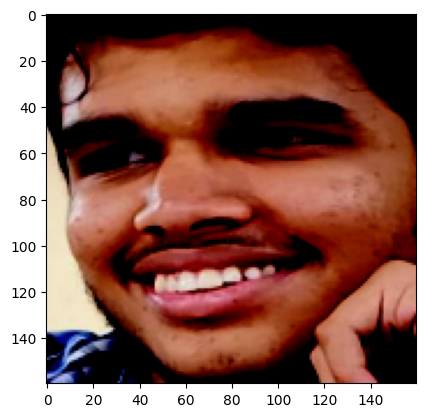

In [10]:
plt.imshow(face.permute(1, 2, 0).clamp(0,1))

## Running over all_images

In [12]:
# Define input and output folders
all_images_dir = r"C:\Users\Archit\Desktop\Frendclassifier\Images\ALL_Images"
cropped_dir    = r"C:\Users\Archit\Desktop\Frendclassifier\Images\Cropped"

os.makedirs(cropped_dir, exist_ok=True)

In [13]:
# Collect all image paths
image_paths = [os.path.join(all_images_dir, f) 
               for f in os.listdir(all_images_dir) 
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

detections = []

for img_path in tqdm(image_paths, desc="Processing images"):
    try:
        img = Image.open(img_path).convert("RGB")
        faces, probs = mtcnn(img, return_prob=True)

        if faces is None:
            detections.append([os.path.basename(img_path), None, None, None, None, None])
            continue

        for i, (face, prob) in enumerate(zip(faces, probs)):
            if prob < 0.95:   # filter low-confidence detections
                continue

            # Convert tensor to PIL for saving (rescale for visualization)
            face_img = face.permute(1, 2, 0).detach().cpu().numpy()
            face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())
            face_pil = Image.fromarray((face_img * 255).astype(np.uint8))

            # Save cropped face
            base = os.path.splitext(os.path.basename(img_path))[0]
            out_name = f"{base}_face{i}.jpg"
            out_path = os.path.join(cropped_dir, out_name)
            face_pil.save(out_path)

            # Log detection
            detections.append([os.path.basename(img_path), out_name, i, float(prob), face.shape[1], face.shape[2]])

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

Processing images: 100%|███████████████████████████████████████████| 354/354 [00:44<00:00,  7.91it/s]


#### Save detections metadata

In [14]:
# Save detections metadata
df = pd.DataFrame(detections, columns=["original_file", "cropped_file", "face_id", "prob", "width", "height"])
df.to_csv("detections.csv", index=False)
df.head()

,original_file,cropped_file,face_id,prob,width,height
0,2025-06-14_20_22_19_836_0.jpg_compressed.JPEG,2025-06-14_20_22_19_836_0.jpg_compressed_face0...,0,0.999902,160,160
1,2025-06-15_18_53_34_151_0.jpg_compressed.JPEG,2025-06-15_18_53_34_151_0.jpg_compressed_face0...,0,0.999961,160,160
2,2025-06-19_19_16_02_593_0.jpg_compressed.JPEG,2025-06-19_19_16_02_593_0.jpg_compressed_face0...,0,0.999996,160,160
3,2025-06-19_19_16_02_593_0.jpg_compressed.JPEG,2025-06-19_19_16_02_593_0.jpg_compressed_face1...,1,0.997943,160,160
4,IMG-20230925-WA0049.jpg_compressed.JPEG,IMG-20230925-WA0049.jpg_compressed_face0.jpg,0,0.998209,160,160


In [16]:
# Summary
print(f"Total images processed: {len(image_paths)}")
print(f"Total faces cropped: {df['cropped_file'].notna().sum()}")

Total images processed: 354
Total faces cropped: 662


### Embedding Extraction
- Load pretrained FaceNet (InceptionResnetV1)
- Generate 512‑D embeddings for each cropped face
- Save embeddings to CSV and NPY for later use

In [17]:
# Load pretrained FaceNet model
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [18]:
# Path to cropped faces
cropped_dir = r"C:\Users\Archit\Desktop\Frendclassifier\Images\Cropped"

cropped_paths = [os.path.join(cropped_dir, f) 
                 for f in os.listdir(cropped_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Total cropped faces found: {len(cropped_paths)}")

Total cropped faces found: 494


In [20]:
import torchvision.transforms as transforms

# FaceNet expects 160x160 RGB normalized images
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # scale to [-1,1]
])

embeddings = []
filenames = []

for path in tqdm(cropped_paths, desc="Extracting embeddings"):
    try:
        img = Image.open(path).convert("RGB")
        face_tensor = transform(img).unsqueeze(0).to(device)  # [1,3,160,160]

        # Get embedding
        with torch.no_grad():
            emb = resnet(face_tensor).cpu().numpy().flatten()

        embeddings.append(emb)
        filenames.append(os.path.basename(path))

    except Exception as e:
        print(f"Error with {path}: {e}")

Extracting embeddings: 100%|██████████████████████████| 494/494 [00:10<00:00, 46.98it/s]


#### Save Embeddings
- Convert embeddings list into a DataFrame
- Save both CSV (readable) and NPY (fast reload) formats

In [21]:
# Convert to DataFrame
embeddings_array = np.array(embeddings)
df_emb = pd.DataFrame(embeddings_array)
df_emb.insert(0, "filename", filenames)

# Save to CSV and NPY
df_emb.to_csv("embeddings.csv", index=False)
np.save("embeddings.npy", embeddings_array)

print(f"Saved embeddings for {len(df_emb)} faces")
df_emb.head()

Saved embeddings for 494 faces


,filename,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,2025-06-14_20_22_19_836_0.jpg_compressed_face0...,0.022149,-0.036797,-0.061052,0.030258,0.004921,0.011317,0.023115,0.012024,0.005444,...,0.004747,-0.019564,-0.027189,0.042944,0.050948,-0.000827,0.037019,-0.030085,-0.027879,0.031972
1,2025-06-15_18_53_34_151_0.jpg_compressed_face0...,0.075480,-0.036982,-0.026518,0.019196,-0.022525,-0.032194,0.023523,0.022999,0.046771,...,-0.036165,-0.035584,-0.054486,-0.012375,-0.062634,0.022194,0.013764,-0.022064,-0.055625,0.036207
2,2025-06-19_19_16_02_593_0.jpg_compressed_face0...,0.015645,-0.000909,0.013530,0.026031,0.016991,0.019433,0.054727,-0.017533,0.036589,...,0.024973,-0.030418,-0.050681,-0.022666,-0.021605,-0.003046,0.021650,-0.018499,-0.077500,0.074828
3,IMG-20230925-WA0049.jpg_compressed_face0.jpg,0.047646,0.007635,0.000570,0.116550,0.001920,0.038173,-0.029718,0.094540,0.030737,...,-0.014352,-0.068666,-0.015689,0.005664,0.031058,0.043528,0.036119,-0.041311,-0.054562,-0.008224
4,IMG-20230925-WA0062.jpg_compressed_face0.jpg,-0.008700,-0.046967,-0.088047,0.025806,0.010204,-0.027785,0.096179,0.035608,-0.024240,...,0.022361,-0.012003,0.002403,-0.013725,-0.034561,0.044244,0.032062,-0.063313,-0.082760,0.008814


#### Summary
- Extracted embeddings for all cropped faces
- Saved results to:
  - `embeddings.csv` (filename + 512 dimensions)
  - `embeddings.npy` (raw array for fast reload)
- Next step: clustering (DBSCAN / KMeans) using these embeddings

In [23]:
print("Embeddings extraction complete ✅")
print(f"Shape of embeddings array: {embeddings_array.shape}")

Embeddings extraction complete ✅
Shape of embeddings array: (494, 512)


#### Clustering
- Load embeddings from CSV/NPY
- Apply dimensionality reduction (optional, for visualization)
- Run clustering (DBSCAN + KMeans)
- Save cluster assignments

In [24]:
# Load embeddings
embeddings = np.load("embeddings.npy")
df_emb = pd.read_csv("embeddings.csv")

print(f"Embeddings shape: {embeddings.shape}")
df_emb.head()

Embeddings shape: (494, 512)


,filename,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,2025-06-14_20_22_19_836_0.jpg_compressed_face0...,0.022149,-0.036797,-0.061052,0.030258,0.004921,0.011317,0.023115,0.012024,0.005444,...,0.004747,-0.019564,-0.027189,0.042944,0.050948,-0.000827,0.037019,-0.030085,-0.027879,0.031972
1,2025-06-15_18_53_34_151_0.jpg_compressed_face0...,0.075480,-0.036982,-0.026518,0.019196,-0.022525,-0.032194,0.023523,0.022999,0.046771,...,-0.036165,-0.035584,-0.054486,-0.012375,-0.062634,0.022194,0.013764,-0.022064,-0.055625,0.036207
2,2025-06-19_19_16_02_593_0.jpg_compressed_face0...,0.015645,-0.000909,0.013530,0.026031,0.016991,0.019433,0.054727,-0.017533,0.036589,...,0.024973,-0.030418,-0.050681,-0.022666,-0.021605,-0.003046,0.021650,-0.018499,-0.077500,0.074828
3,IMG-20230925-WA0049.jpg_compressed_face0.jpg,0.047646,0.007635,0.000570,0.116550,0.001920,0.038173,-0.029718,0.094540,0.030737,...,-0.014352,-0.068666,-0.015689,0.005664,0.031058,0.043528,0.036119,-0.041311,-0.054562,-0.008224
4,IMG-20230925-WA0062.jpg_compressed_face0.jpg,-0.008700,-0.046968,-0.088047,0.025806,0.010204,-0.027785,0.096179,0.035608,-0.024240,...,0.022361,-0.012003,0.002403,-0.013725,-0.034561,0.044244,0.032062,-0.063313,-0.082760,0.008814


#### Visualizing Embeddings

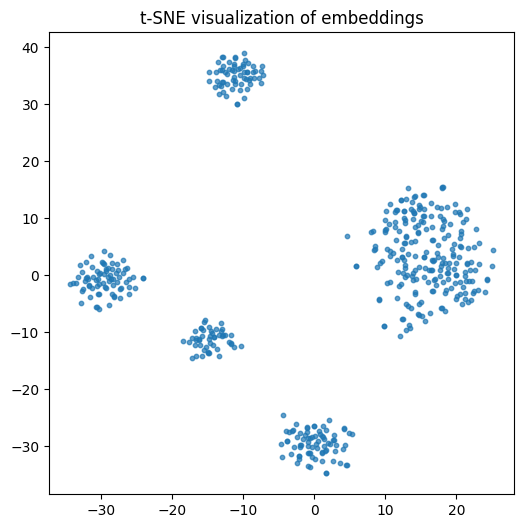

In [25]:
# Reduce to 2D for visualization
pca = PCA(n_components=50).fit_transform(embeddings)   # speed up t-SNE
tsne = TSNE(n_components=2, random_state=42).fit_transform(pca)

plt.figure(figsize=(6,6))
plt.scatter(tsne[:,0], tsne[:,1], s=10, alpha=0.7)
plt.title("t-SNE visualization of embeddings")
plt.show()

### DBSCAN Clustering (NOT GIVING GOOD RESULTS)
- Density-based clustering (auto cluster count)
- Good for finding core groups + filtering noise

In [26]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=3, metric='cosine').fit(embeddings)
df_emb["dbscan_cluster"] = dbscan.labels_

print(df_emb["dbscan_cluster"].value_counts())

dbscan_cluster
 0    493
-1      1
Name: count, dtype: int64


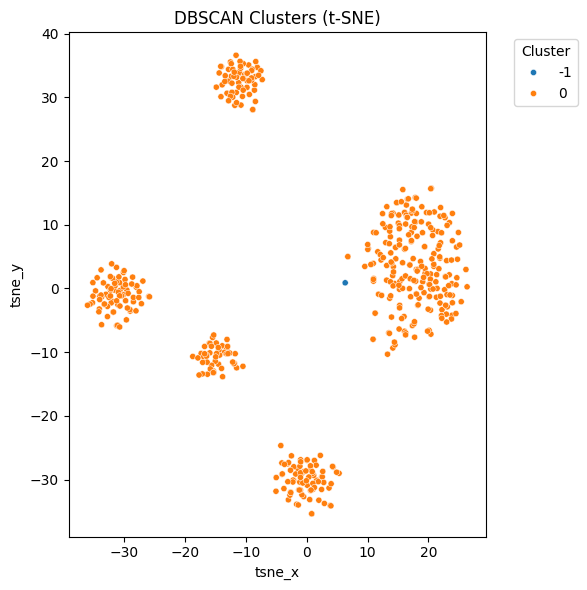

In [33]:
# t-SNE for visualization
tsne_db = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
df_emb["tsne_x"] = tsne_db[:, 0]
df_emb["tsne_y"] = tsne_db[:, 1]

# Plot DBSCAN clusters
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_emb, x="tsne_x", y="tsne_y", hue="dbscan_cluster", palette="tab10", s=20)
plt.title("DBSCAN Clusters (t-SNE)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## KMeans Clustering
- Specify number of clusters (you expect ~5 friends)
- Compare with DBSCAN results

In [45]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42).fit(embeddings)
df_emb["kmeans_cluster"] = kmeans.labels_

print(df_emb["kmeans_cluster"].value_counts())

kmeans_cluster
2    187
4     77
3     77
1     65
5     52
0     36
Name: count, dtype: int64


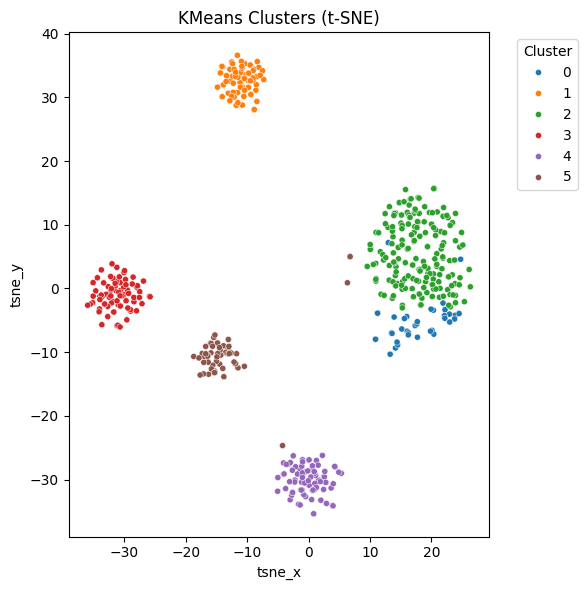

In [46]:
# t-SNE already computed above (reuse tsne_db)
df_emb["tsne_x"] = tsne_db[:, 0]
df_emb["tsne_y"] = tsne_db[:, 1]

# Plot KMeans clusters
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_emb, x="tsne_x", y="tsne_y", hue="kmeans_cluster", palette="tab10", s=20)
plt.title("KMeans Clusters (t-SNE)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Save Cluster Assignments
- Save cluster IDs alongside filenames and embeddings
- Output: `clusters.csv`


In [47]:
df_emb.to_csv("clusters.csv", index=False)
df_emb.head()

,filename,0,1,2,3,4,5,6,7,8,...,506,507,508,509,510,511,dbscan_cluster,kmeans_cluster,tsne_x,tsne_y
0,2025-06-14_20_22_19_836_0.jpg_compressed_face0...,0.022149,-0.036797,-0.061052,0.030258,0.004921,0.011317,0.023115,0.012024,0.005444,...,0.050948,-0.000827,0.037019,-0.030085,-0.027879,0.031972,0,2,25.370558,-2.074329
1,2025-06-15_18_53_34_151_0.jpg_compressed_face0...,0.075480,-0.036982,-0.026518,0.019196,-0.022525,-0.032194,0.023523,0.022999,0.046771,...,-0.062634,0.022194,0.013764,-0.022064,-0.055625,0.036207,0,2,19.015411,8.759066
2,2025-06-19_19_16_02_593_0.jpg_compressed_face0...,0.015645,-0.000909,0.013530,0.026031,0.016991,0.019433,0.054727,-0.017533,0.036589,...,-0.021605,-0.003046,0.021650,-0.018499,-0.077500,0.074828,0,2,24.653538,1.684848
3,IMG-20230925-WA0049.jpg_compressed_face0.jpg,0.047646,0.007635,0.000570,0.116550,0.001920,0.038173,-0.029718,0.094540,0.030737,...,0.031058,0.043528,0.036119,-0.041311,-0.054562,-0.008224,0,4,-5.044034,-31.825356
4,IMG-20230925-WA0062.jpg_compressed_face0.jpg,-0.008700,-0.046968,-0.088047,0.025806,0.010204,-0.027785,0.096179,0.035608,-0.024240,...,-0.034561,0.044244,0.032062,-0.063313,-0.082760,0.008814,0,5,-14.479462,-11.879640


### Compare KMeans with k = 5, 6, 7
- Run KMeans clustering with different values of k
- Visualize each result using t-SNE

In [50]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Reduce embeddings to 2D for plotting
tsne = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Store results
k_values = [5, 6, 7]
cluster_results = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
    cluster_results[k] = kmeans.labels_

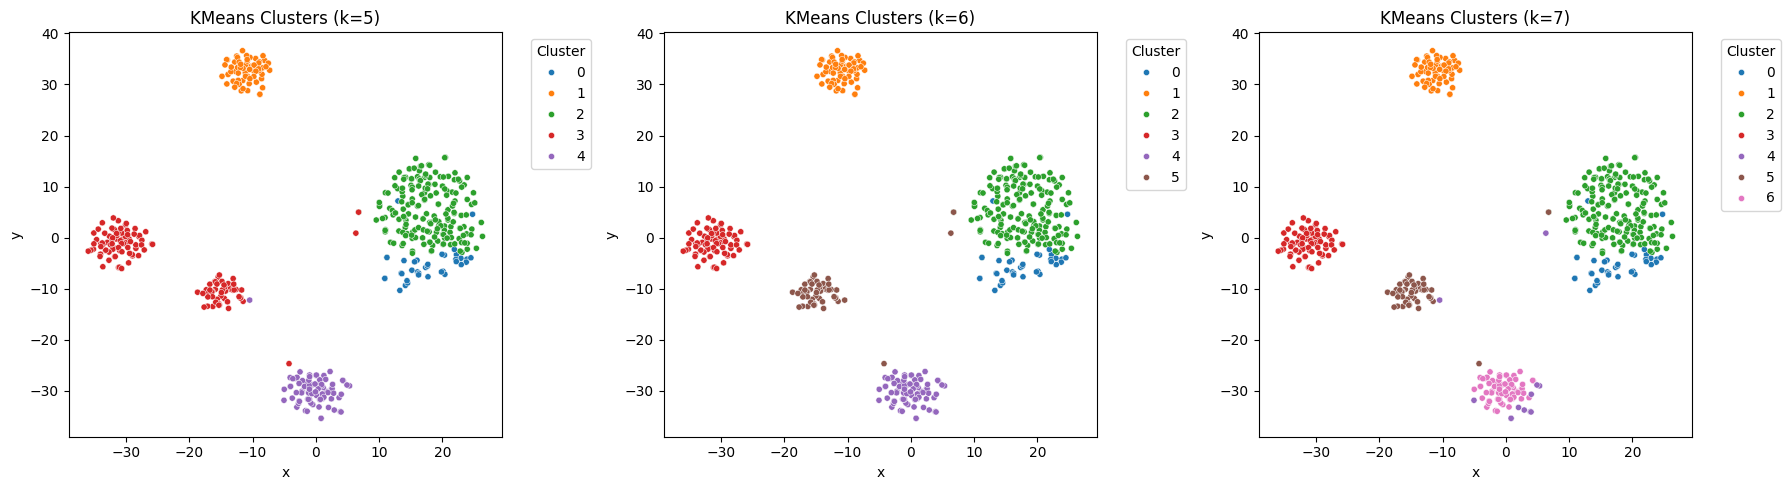

In [51]:
# Plot each clustering result
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, k in enumerate(k_values):
    df_plot = pd.DataFrame({
        "x": tsne[:, 0],
        "y": tsne[:, 1],
        "cluster": cluster_results[k]
    })
    sns.scatterplot(data=df_plot, x="x", y="y", hue="cluster", palette="tab10", s=20, ax=axes[i])
    axes[i].set_title(f"KMeans Clusters (k={k})")
    axes[i].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## So we stick with 6 clusters

### Organize Clustered Faces
- Create folders: `Images/Clustered/cluster_0/`, ..., `cluster_5/`
- Copy each cropped face into its assigned cluster folder

In [52]:
import shutil

# Source: cropped faces
cropped_dir = r"C:\Users\Archit\Desktop\Frendclassifier\Images\Cropped"
# Destination: clustered folders
clustered_dir = r"C:\Users\Archit\Desktop\Frendclassifier\Images\Clustered"

# Load cluster assignments
df = pd.read_csv("clusters.csv")

# Use KMeans cluster column
cluster_col = "kmeans_cluster"

for cluster_id in sorted(df[cluster_col].unique()):
    cluster_path = os.path.join(clustered_dir, f"cluster_{cluster_id}")
    os.makedirs(cluster_path, exist_ok=True)

# Copy images into cluster folders
for _, row in tqdm(df.iterrows(), total=len(df), desc="Organizing clusters"):
    src = os.path.join(cropped_dir, row["filename"])
    dst = os.path.join(clustered_dir, f"cluster_{row[cluster_col]}", row["filename"])
    try:
        shutil.copy(src, dst)
    except Exception as e:
        print(f"Error copying {row['filename']}: {e}")

Organizing clusters: 100%|███████████████████████████| 494/494 [00:00<00:00, 926.00it/s]
